# Probablilistic Finite State Automata

In [1]:
%matplotlib inline
import logging
logging.basicConfig(level=logging.INFO)

from numpy import *
from wfsa import WFSA, PFSA, Sample, csra_matrix, FileBatch

In [2]:
from contextlib import contextmanager
from time import time
Tests = (
  ('avglen',dict(
    title='Expected length',
    empirical=lambda X,start,sample: sum([sum(batch!=X.stop) for batch,_ in sample.content])/sample.size,
    theoretical=lambda X,start: X.expected_length(start),
  )),
  ('entropy',dict(
    title='Entropy',
    empirical=lambda X,start,sample: -mean(X.logproba(sample,start)),
    theoretical=lambda X,start: X.entropy(start),
  )),
)
@contextmanager
def ptime():
  t = time()
  try:
    try: yield
    except: print('Error!',end=''); raise
  finally: print(' [{:.3g}s]'.format(time()-t))
def test(X,nsample,start=0,**alt):
  X.deterministic
  print('Producing sample of size',nsample,end='',flush=True)
  with ptime():
    X.asample = sample = X.sample(nsample,start,store=FileBatch('samples',clear=True).store)
    print(' on {} batches'.format(len(sample.content)),end='')
  try:
    for key,D in Tests:
      print(D['title'])
      print('\tempirical  : ',end='',flush=True)
      with ptime(): v = D['empirical'](X,start,sample); print('{:.15g}'.format(v),end='')
      print('\ttheoretical: ',end='',flush=True)
      with ptime(): v = D['theoretical'](X,start); print('{:.15g}'.format(v),end='')
      v = alt.get(key)
      if v is not None: print('\talternative: {:.15g}'.format(v))
  finally:
    print('Sample ({}/{})'.format(10,nsample))
    sample.pprint(X.symb_names,10,translate={ord(X.symb_names[X.stop]):''})
def display_html(X):
  from IPython.display import display_html
  display_html(X.as_html(),raw=True)

## Basic example

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,A,B,O,F
A,0.8,,0.2,
B,,0.6,0.4,
O,0.3,0.5,,0.2
F,,,,1.0


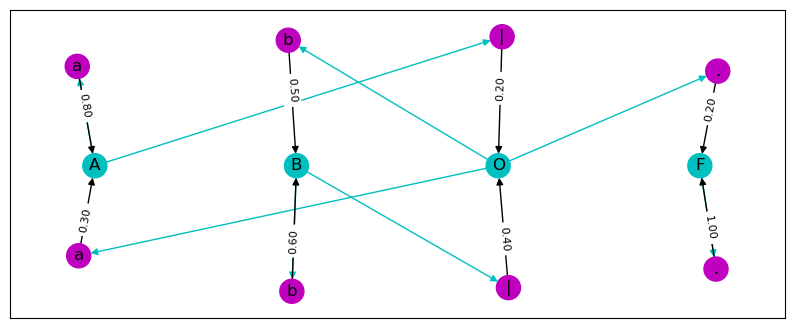

In [3]:
X = PFSA.from_str('''
A->A a .8
A->O | .2
B->B b .6
B->O | .4
O->A a .3
O->B b .5
O->F . .2
F->F . 1.
''')
display_html(X)
X.draw(figsize=(10,4))

Draw a large sample from state 'O'

In [4]:
sample = test(X,100000,start='O')

Producing sample of size 100000 on 13 batches [0.418s]
Expected length
	empirical  : 17.84723 [0.00655s]
	theoretical: 17.75 [3.55e-05s]
Entropy
	empirical  : 13.1704279117247 [0.592s]
	theoretical: 13.1076061656671 [0.000246s]
Sample (10/100000)
78849    12   bbbbb|bbbbb|
69828     6   b|b|b|
87941     9   bb|aaaaa|
92109     7   a|a|bb|
 2853    68   a|b|a|bb|bbb|aaaaaaa|aaa|bbb|a|bbbb|aaaaaa|aaaa|b|b|aaaa|a|aa|b|aaa|
88037     8   aaaa|bb|
20163    25   b|aaaaa|aaaaaa|aaaaaaaaa|
83750    10   aaa|bbb|a|
12325    44   b|b|aaaaaaaaaaaaa|aaaaaaaaaaaa|b|b|bb|aa|aa|
82215     5   bb|b|


## Another example with super easy entropy

Closed form of entropy: $\frac{-p\log p-q\log q}{q}$

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,O,F
O,0.7,0.3
F,,1.0


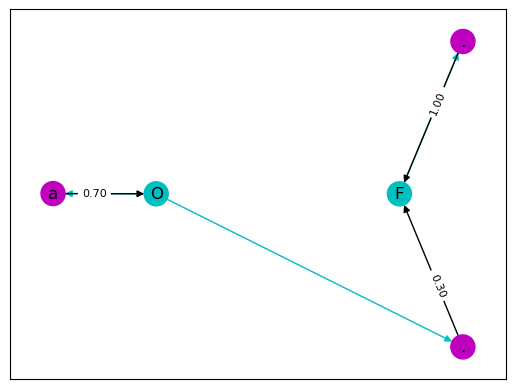

In [5]:
p = .7; q = 1.-p
X = PFSA.from_str('''
O->O a {}
O->F . {}
F->F . 1.
'''.format(p,q))
display_html(X)
X.draw(dict(k=.7,K=2.))

In [6]:
sample = test(X,100000,start='O',avglen=p/q,entropy=-(p*log(p)+q*log(q))/q)

Producing sample of size 100000 on 9 batches [0.0607s]
Expected length
	empirical  : 2.3368 [0.00129s]
	theoretical: 2.33333333333333 [3.79e-05s]
	alternative: 2.33333333333333
Entropy
	empirical  : 2.03745081332197 [0.0733s]
	theoretical: 2.03621434018298 [0.00018s]
	alternative: 2.03621434018298
Sample (10/100000)
37268    2   aa
12034    5   aaaaa
57389    0   
60162    1   a
83541    2   aa
17278    5   aaaaa
74079    2   aa
99009    1   a
  332   17   aaaaaaaaaaaaaaaaa
79708    2   aa


## Other example with sparse matrices

Closed form of entropy: $L(-p\log p-q\log q)$

In [7]:
p =.7; L = 100; q = 1.-p
W = [*(z*eye(L+1,k=1) for z in (p,q)),zeros((L+1,L+1))]
W[-1][-1,-1] = 1
W = [csra_matrix.initial(w) for w in W]
X = PFSA(W,symb_names=('a','b','.'))

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . 100


In [8]:
display_html(X)

🛈


In [9]:
sample = test(X,10000,start=0,avglen=L,entropy=-L*(p*log(p)+q*log(q)))

Producing sample of size 10000 on 1 batches [0.0941s]
Expected length
	empirical  : 100 [0.00229s]
	theoretical: 100 [4.01e-05s]
	alternative: 100
Entropy
	empirical  : 61.153451466246 [8.77s]
	theoretical: 61.0864302054893 [0.00131s]
	alternative: 61.0864302054893
Sample (10/10000)
3587   100   bbababaabbabaaabababaaaaabbaaaabbbaaaaaaaaabbaaababaabaaaaaaaaabaaaabaaaaaaaabaaabaaaaaaaabbbababaaa
9388   100   baabaaaababaabbaaaaabababaabaabbaabbaababaaaabaababbabbbbabaabbaaaabaaabbbaaaabbbbaaaaaabaaaaabbbaaa
7571   100   baaaaaabaaaaabaaaaaaabbaabaaaaaaaaabaabaabaaaabbaabbbaabbbbaaabaaaaabbaaaaaaaaaaaabbababaaaabaababaa
8490   100   ababaaaabaaabbabaaabaaabaaaaaaababaababaabaaabaaabababaaaaaaaabaaaaabaabaabbbaaaaabbaaaaaabbaaabaaaa
5366   100   baaaabaaaaaaaaaaabaabaaaabaaabaaababbaabababaabaabbbaaabbababaabbaaaaaabaaaaaaaaaabaababbaabaaabaaba
3512   100   abaaaabaababaaabbbbaaaabaaaaaabaaaabbabaababaababbaaaaaabaabbbaababaaabaaabbaaaabbaaabaaaaaabbbbbaab
 748   100   aaaaababbaaaaaaaaaa

## Pruning

In [10]:
X = WFSA.from_str('''
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
F->F . 1.
U->V | 1
U->V a 1
U->V b 1
V->U | 1
V->U a 1
V->U b 1
U->W | 1
U->W a 1
U->W b 1
V->W | 1
V->W a 1
V->W b 1
W->W | 0
''')

In [11]:
display_html(X)
X = X.toPFSA()
display_html(X)

🛈,O,A,B,F,U,V,W
O,,0.3,0.5,0.2,,,
A,0.2,0.8,,,,,
B,0.4,,0.6,,,,
F,,,,1.0,,,
U,,,,,,3.0,3.0
V,,,,,3.0,,3.0
W,,,,,,,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F
INFO:wfsa.probabilistic:Pruning unreachable states: 3/7


🛈,O,A,B,F
O,,0.3,0.5,0.2
A,0.2,0.8,,
B,0.4,,0.6,
F,,,,1.0


## Intersection

In [12]:
L = 5
template,wstop = eye(L+1,k=1),zeros((L+1,L+1)); wstop[-1,-1] = 1.
template,wstop = map(csra_matrix.initial,(template,wstop))
X_len = WFSA([wstop],template=template,symb_names=('.',),state_names=[f'L{k}' for k in range(L,-1,-1)])

X_cnt = WFSA.from_str('''
O->O a .35
O->O b .15
O->O . 1
''',sparse=True)

X_mot = WFSA.from_str('''
O->A a 1
O->O b 1
A->F b 1
A->A a 1
F->F a 1
F->F b 1
F->F . 1
''',sparse=True)

In [13]:
X = X_len@X_mot@X_cnt
display_html(X)

🛈,L5.O.O,L5.A.O,L5.F.O,L4.O.O,L4.A.O,L4.F.O,L3.O.O,L3.A.O,L3.F.O,L2.O.O,L2.A.O,L2.F.O,L1.O.O,L1.A.O,L1.F.O,L0.O.O,L0.A.O,L0.F.O
L5.O.O,,,,0.15,0.35,,,,,,,,,,,,,
L5.A.O,,,,,0.35,0.15,,,,,,,,,,,,
L5.F.O,,,,,,0.5,,,,,,,,,,,,
L4.O.O,,,,,,,0.15,0.35,,,,,,,,,,
L4.A.O,,,,,,,,0.35,0.15,,,,,,,,,
L4.F.O,,,,,,,,,0.5,,,,,,,,,
L3.O.O,,,,,,,,,,0.15,0.35,,,,,,,
L3.A.O,,,,,,,,,,,0.35,0.15,,,,,,
L3.F.O,,,,,,,,,,,,0.5,,,,,,
L2.O.O,,,,,,,,,,,,,0.15,0.35,,,,


In [14]:
X = X.toPFSA()
display_html(X)

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . L0.F.O
INFO:wfsa.probabilistic:Pruning unreachable states: 3/18
INFO:wfsa.probabilistic:Normaliser min: 0.022115625 max: 1.0


🛈,L5.O.O,L5.A.O,L5.F.O,L4.O.O,L4.A.O,L4.F.O,L3.O.O,L3.A.O,L3.F.O,L2.O.O,L2.A.O,L2.F.O,L1.A.O,L1.F.O,L0.F.O
L5.O.O,,,,0.25,0.75,,,,,,,,,,
L5.A.O,,,,,0.64,0.36,,,,,,,,,
L5.F.O,,,,,,1.0,,,,,,,,,
L4.O.O,,,,,,,0.22,0.78,,,,,,,
L4.A.O,,,,,,,,0.61,0.39,,,,,,
L4.F.O,,,,,,,,,1.0,,,,,,
L3.O.O,,,,,,,,,,0.15,0.85,,,,
L3.A.O,,,,,,,,,,,0.54,0.46,,,
L3.F.O,,,,,,,,,,,,1.0,,,
L2.O.O,,,,,,,,,,,,,1.0,,


In [15]:
def allstr(X,L):
  R = [c for c in range(len(X.W)) if c!=X.stop]
  m = X.n-1
  sample = empty((L+1,Q),dtype=int)
  sample[L] = X.stop
  for k in range(L): sample[k] = tile(repeat(R,m**(L-1-k)),m**k)
  return sample
Q = (X.n-1)**L
sample = Sample(Q)
sample.append(allstr(X,L))
X.asample = sample.close()

In [16]:
P = exp(X.logproba(sample,start=f'L{L}.O.O'))
for x,p in zip(sample.values(),P): print(''.join(X.symb_names[c] for c in x),p)
print('Total probability:',sum(P))
print('Entropy:',X.entropy(start=f'L{L}.O.O'))

aaaaa. 0.0
aaaab. 0.10178041543026706
aaaba. 0.10178041543026702
aaabb. 0.043620178041543015
aabaa. 0.10178041543026706
aabab. 0.043620178041543015
aabba. 0.043620178041543015
aabbb. 0.01869436201780415
abaaa. 0.10178041543026702
abaab. 0.043620178041543015
ababa. 0.043620178041543015
ababb. 0.01869436201780415
abbaa. 0.043620178041543015
abbab. 0.01869436201780415
abbba. 0.01869436201780415
abbbb. 0.008011869436201781
baaaa. 0.0
baaab. 0.043620178041543015
baaba. 0.043620178041542994
baabb. 0.018694362017804136
babaa. 0.043620178041543015
babab. 0.01869436201780415
babba. 0.01869436201780415
babbb. 0.008011869436201781
bbaaa. 0.0
bbaab. 0.01869436201780416
bbaba. 0.01869436201780415
bbabb. 0.008011869436201781
bbbaa. 0.0
bbbab. 0.008011869436201781
bbbba. 0.0
bbbbb. 0.0
Total probability: 0.9999999999999997
Entropy: 2.9841468787729934


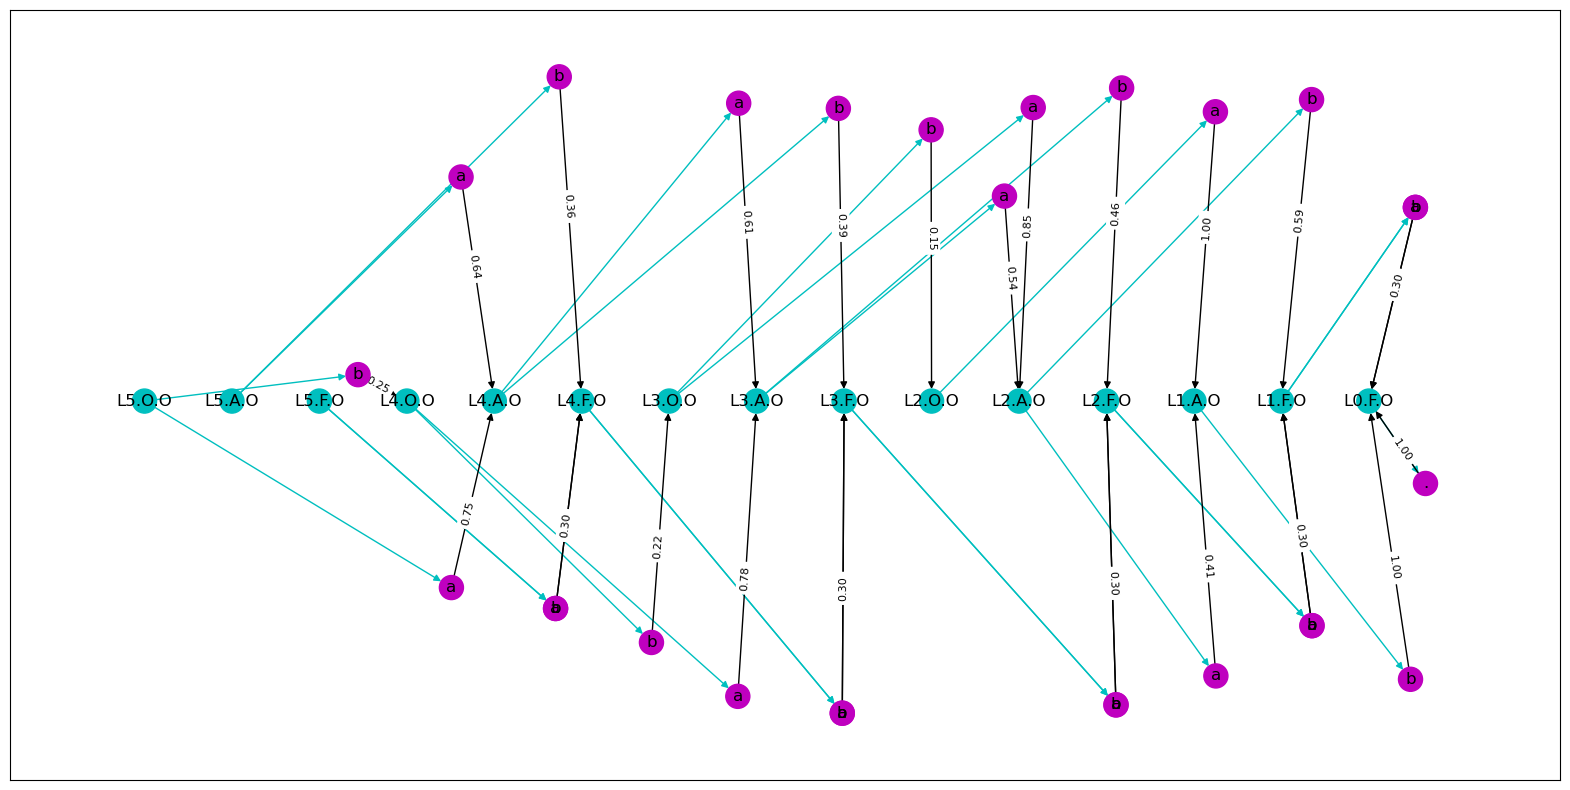

In [17]:
X.draw(figsize=(20,10),tune=dict(k=6.,K=18.))

## Entropy not computable

In [18]:
X = PFSA.from_str('''
O->A3 [ .3
O->A2 [ .2
O->A1 [ .1
O->B b .25
O->F . .15
B->B b .8
B->O b .2
A3->A2 a 1.
A2->A1 a 1.
A1->A0 a 1.
A0->O ] 1.
F->F . 1.
''')

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


In [19]:
display_html(X)

🛈,O,B,A3,A2,A1,A0,F
O,,0.25,0.3,0.2,0.1,,0.15
B,0.2,0.8,,,,,
A3,,,,1.0,,,
A2,,,,,1.0,,
A1,,,,,,1.0,
A0,1.0,,,,,,
F,,,,,,,1.0


In [20]:
sample = test(X,10000,start='O')

Producing sample of size 10000 on 11 batches [0.254s]
Expected length
	empirical  : 27.46 [0.00106s]
	theoretical: 27.3333333333333 [5.03e-05s]
Entropy
	empirical  : 12.9914432180775 [0.174s]
	theoretical: Error! [9.68e-05s]
Sample (10/10000)
6292     4   [aa]
7759     3   [a]
1914    56   [aa][aaa][aa][aa][aaa][aaa][aaa][a][a][aaa][aa][aa][aaa]
 618    72   [aa][aa][a][aa][aaa][aa][aaa][aa]bbbb[aaa]bbbbbbbbbbbb[aaa][aa]bb[a][aa]
4931     7   [a][aa]
6755     0   
1276    76   [a]bbbbbbbb[aa][aa][aa]bbb[aa][a][aaa]bbbbbbbb[aaa]bbbbbbbbbbbbbbbb[aa]bbbbb
3838     4   [aa]
5873     7   [aa][a]
6575    26   [aa][aaa][aa][aa][aa]bbbbb


NotImplementedError: Entropy available only for deterministic automata

# Sample management

In [21]:
R = FileBatch('samples')
sample = R.toSample()
sample

In [22]:
sample.pprint('[b.a]',pick=10,translate={ord('.'):''})

4149    21   [aa]bbbbbbbbbbbb[aaa]
7898    26   [a]bbbbbbbbb[aaa]bbbb[aaa]
 369   106   [aa]bbbbbbb[aa][aaa]bbbbbbbbbbbbbb[aaa][aaa][aaa][aaa][aaa]bbbbbb[aaa]bbb[aa]bbbbbb[aaa][aaa][aaa][aa][aa]
4410    20   [aaa]bbbbb[aaa][aaa]
3806    18   [aaa][aa][aa][aaa]
 651    72   bbb[aaa]bbbb[aa]bbbbbbbbbbbbbbbb[aaa][aa][aa][aaa][aaa]bbbb[a][aaa][aaa]
2292    46   [aa]bb[aaa][a]bbbbbbbbbbbb[aaa]bbbbbbb[aa][aa]
7275     0   
7080     0   
6623     0   
